<a href="https://colab.research.google.com/github/Seemab22/ThesisActivity/blob/main/2_IHR_Data_Visualization_Activity_Label_Recg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hyperparameter	Value


frame_size (sequence length)	100


feature_cols	6 features (acceleration X,Y,Z + angular X,Y,Z)


d_model (embedding size)	64


n_head (attention heads)	4


n_layers (encoder layers)	2


hidden (feedforward size)	128


dropout	0.3


n_classes	4 (HES, HER, TOF, FOF)


batch_size	32


learning_rate	5e-5


optimizer	AdamW (weight_decay=1e-4)


epochs	50


loss_fn	Focal Loss (γ=2, α=class weights)


cross-validation folds	5

In [ ]:
import time, copy, math, os
import numpy as np, pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
frame_size = 100
feature_cols = [
    'left acceleration X[g]',
    'left acceleration Y[g]',
    'left acceleration Z[g]',
    'left angular X[dps]',
    'left angular Y[dps]',
    'left angular Z[dps]',
]
label_map = {'HEEL':0,'TOF':1,'FOF':2}  # ✅ Merged HER & HES → HEEL

In [ ]:
# ========================== DATASET ==============================
class IMUDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32).reshape(-1, frame_size, len(feature_cols))
        self.Y = torch.tensor(Y, dtype=torch.long)
    def __len__(self): return len(self.Y)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]

# ====================== DATA PROCESSING ===========================
def process_file(filepath, overlap=0.5):
    df = pd.read_excel(filepath)
    df = df.dropna(subset=feature_cols+['Event- Label level 2- Left Foot'])

    # ✅ Merge HER & HES → HEEL
    df['label'] = df['Event- Label level 2- Left Foot'].replace({'HES':'HEEL','HER':'HEEL'})
    df = df[df['label'].isin(['HEEL','TOF','FOF'])]  # Filter only required classes
    df['label'] = df['label'].map(label_map)

    frames, labels = [], []
    step_size = int(frame_size * (1-overlap))  # 50% overlap
    for i in range(0, len(df)-frame_size+1, step_size):
        segment = df.iloc[i:i+frame_size]
        label = np.bincount(segment['label']).argmax()
        frames.append(segment[feature_cols].values.flatten())
        labels.append(label)
    return frames, labels

def load_all_group_data(root_dir, groups):
    all_frames, all_labels = [], []
    print("\nLoading data...")
    for group in groups:
        group_path = os.path.join(root_dir, group)
        for file in os.listdir(group_path):
            if file.endswith('.xlsx'):
                try:
                    frames, labels = process_file(os.path.join(group_path, file), overlap=0.5)
                    all_frames += list(frames)
                    all_labels += list(labels)
                except KeyError as e:
                    print(f"File skipped due to missing columns: {file}")
                    print(f"Missing columns error: {e}")
                    continue

    all_frames, all_labels = np.array(all_frames), np.array(all_labels)
    print("Loaded:", all_frames.shape, "Labels:", Counter(all_labels))

    counts = Counter(all_labels)
    plt.figure(figsize=(6,4))
    plt.bar([list(label_map.keys())[i] for i in counts.keys()], counts.values(), color='skyblue')
    plt.title('Class Distribution After Loading Data')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.show()

    return all_frames, all_labels


In [ ]:
# ==================== Focal Loss ===============================
class FocalLoss(nn.Module):
    def __init__(self,alpha=None,gamma=2):
        super().__init__(); self.alpha=alpha; self.gamma=gamma
        self.ce=nn.CrossEntropyLoss(weight=alpha)
    def forward(self,inputs,targets):
        ce_loss=self.ce(inputs,targets)
        pt=torch.exp(-ce_loss)
        return ((1-pt)**self.gamma*ce_loss).mean()

# ==================== Transformer Model =========================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0,max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0,d_model,2)*(-math.log(10000.0)/d_model))
        pe[:,0::2], pe[:,1::2] = torch.sin(pos*div), torch.cos(pos*div)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self,x):
        return x+self.pe[:,:x.size(1)]

class MultiHeadAttention(nn.Module):
    def __init__(self,d_model,n_head):
        super().__init__(); self.n_head=n_head; self.d_head=d_model//n_head
        self.qkv=nn.Linear(d_model,3*d_model); self.o=nn.Linear(d_model,d_model)
    def forward(self,x):
        B,T,C=x.shape
        qkv=self.qkv(x).reshape(B,T,3,self.n_head,self.d_head).permute(2,0,3,1,4)
        q,k,v=qkv[0],qkv[1],qkv[2]
        attn=torch.matmul(q,k.transpose(-2,-1))/math.sqrt(self.d_head)
        attn=attn.softmax(-1)
        out=torch.matmul(attn,v).transpose(1,2).reshape(B,T,C)
        return self.o(out)

class FeedForward(nn.Module):
    def __init__(self,d_model,hidden,drop=0.3):
        super().__init__()
        self.net=nn.Sequential(nn.Linear(d_model,hidden),nn.ReLU(),nn.Dropout(drop),nn.Linear(hidden,d_model))
    def forward(self,x): return self.net(x)

class EncoderLayer(nn.Module):
    def __init__(self,d_model,n_head,hidden,drop=0.3):
        super().__init__()
        self.attn=MultiHeadAttention(d_model,n_head)
        self.norm1, self.norm2 = nn.LayerNorm(d_model), nn.LayerNorm(d_model)
        self.ff=FeedForward(d_model,hidden,drop)
    def forward(self,x):
        x=self.norm1(x+self.attn(x))
        return self.norm2(x+self.ff(x))

class TransformerModel(nn.Module):
    def __init__(self,d_model=64,n_head=4,n_layers=2,hidden=128,n_classes=3,seq_len=100):  # ✅ n_classes=3
        super().__init__()
        self.proj=nn.Sequential(nn.Linear(6,d_model),nn.BatchNorm1d(seq_len))
        self.pos=PositionalEncoding(d_model)
        self.layers=nn.ModuleList([EncoderLayer(d_model,n_head,hidden) for _ in range(n_layers)])
        self.head=nn.Sequential(nn.Flatten(),nn.Linear(d_model*seq_len,256),nn.ReLU(),nn.Dropout(0.3),nn.Linear(256,n_classes))
    def forward(self,x):
        x=self.proj(x); x=self.pos(x)
        for layer in self.layers: x=layer(x)
        return self.head(x)

# ==================== TRAINING UTILS ==============================
def train_one_epoch(model,loader,opt,scaler,loss_fn):
    model.train(); total_loss=0; correct=0; total=0
    for x,y in loader:
        x,y=x.to(device),y.to(device); opt.zero_grad()
        with autocast():
            out=model(x); loss=loss_fn(out,y)
        scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
        total_loss+=loss.item()*x.size(0)
        correct+=(out.argmax(1)==y).sum().item(); total+=y.size(0)
    return total_loss/total, correct/total

def validate(model,loader,loss_fn):
    model.eval(); total_loss=0; correct=0; total=0; preds=[]; labels=[]
    with torch.no_grad():
        for x,y in loader:
            x,y=x.to(device),y.to(device)
            out=model(x); loss=loss_fn(out,y)
            total_loss+=loss.item()*x.size(0)
            correct+=(out.argmax(1)==y).sum().item(); total+=y.size(0)
            preds.extend(out.argmax(1).cpu().numpy()); labels.extend(y.cpu().numpy())
    return total_loss/total, correct/total, preds, labels

In [ ]:
# ==================== CROSS VALIDATION =============================
def cross_validate(frames,labels,root_dir,k=5,epochs=200,batch_size=32,lr=1e-4,patience=20):
    skf=StratifiedKFold(n_splits=k,shuffle=True,random_state=42)
    results=[]; scaler=StandardScaler(); frames=scaler.fit_transform(frames)
    weights=compute_class_weight('balanced',classes=np.arange(3),y=labels)  # ✅ updated for 3 classes
    alpha=torch.tensor(weights,dtype=torch.float32).to(device)

    for fold,(tr,va) in enumerate(skf.split(frames,labels),1):
        print(f"\n===== Fold {fold}/{k} =====")
        Xtr,Ytr=frames[tr],labels[tr]; Xva,Yva=frames[va],labels[va]
        ros=RandomOverSampler(sampling_strategy='auto'); Xtr,Ytr=ros.fit_resample(Xtr,Ytr)
        print("After oversampling:",Counter(Ytr))

        train_loader=DataLoader(IMUDataset(Xtr,Ytr),batch_size=batch_size,shuffle=True)
        val_loader=DataLoader(IMUDataset(Xva,Yva),batch_size=batch_size)

        model=TransformerModel().to(device)
        opt=AdamW(model.parameters(),lr=lr,weight_decay=1e-4)
        loss_fn=FocalLoss(alpha)
        amp_scaler=GradScaler()

        best_acc=0; patience_counter=0
        best_wts=copy.deepcopy(model.state_dict())
        history={"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[]}

        for ep in range(epochs):
            tr_loss,tr_acc=train_one_epoch(model,train_loader,opt,amp_scaler,loss_fn)
            va_loss,va_acc,preds,labs=validate(model,val_loader,loss_fn)

            history["train_loss"].append(tr_loss)
            history["val_loss"].append(va_loss)
            history["train_acc"].append(tr_acc)
            history["val_acc"].append(va_acc)

            print(f"Epoch {ep+1}: Train Acc={tr_acc:.3f} | Val Acc={va_acc:.3f}")

            if va_acc>best_acc:
                best_acc=va_acc
                best_wts=copy.deepcopy(model.state_dict())
                patience_counter=0
            else:
                patience_counter+=1
                if patience_counter>=patience:
                    print(f"Early stopping at epoch {ep+1}")
                    break

        model.load_state_dict(best_wts)

        # Plot loss/accuracy
        epochs_range=range(1,len(history["train_loss"])+1)
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(epochs_range,history["train_loss"],label="Train Loss")
        plt.plot(epochs_range,history["val_loss"],label="Val Loss")
        plt.legend(); plt.title(f"Fold {fold} Loss")

        plt.subplot(1,2,2)
        plt.plot(epochs_range,history["train_acc"],label="Train Acc")
        plt.plot(epochs_range,history["val_acc"],label="Val Acc")
        plt.legend(); plt.title(f"Fold {fold} Accuracy")
        plt.show()

        acc=accuracy_score(labs,preds)
        prec=precision_score(labs,preds,average='weighted')
        rec=recall_score(labs,preds,average='weighted')
        f1=f1_score(labs,preds,average='weighted')

        print(f"Fold {fold} Final: Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} F1={f1:.3f}")

        cm=confusion_matrix(labs,preds)
        sns.heatmap(cm,annot=True,fmt='d',xticklabels=label_map.keys(),yticklabels=label_map.keys())
        plt.title(f"Confusion Matrix Fold {fold}")
        plt.show()

        results.append({'fold':fold,'acc':acc,'prec':prec,'rec':rec,'f1':f1})

    df=pd.DataFrame(results)
    df.to_csv(f"{root_dir}/cv_metrics.csv",index=False)
    print("\nAverage:",df[['acc','prec','rec','f1']].mean())
    return df


Loading data...
File skipped due to missing columns: pd004_1norm2.xlsx
Missing columns error: ['left acceleration X[g]', 'left acceleration Y[g]', 'left acceleration Z[g]', 'left angular X[dps]', 'left angular Y[dps]', 'left angular Z[dps]']
Loaded: (6171, 600) Labels: Counter({np.int64(0): 2337, np.int64(1): 2230, np.int64(2): 1604})


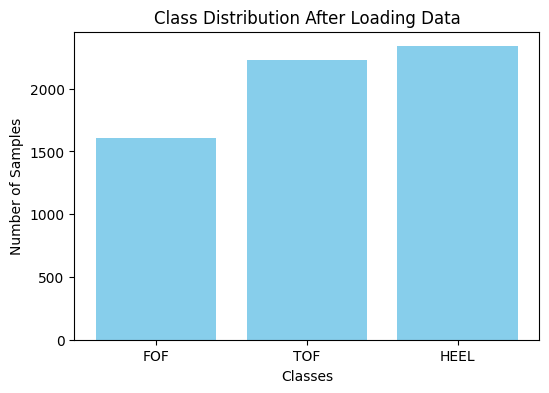

In [ ]:
# ==================== USAGE =============================
root_dir = '/content/drive/MyDrive/IMU/Annotated_Data'
groups = ['PD','EL']
frames,labels=load_all_group_data(root_dir,groups)


===== Fold 1/5 =====
After oversampling: Counter({np.int64(2): 1869, np.int64(0): 1869, np.int64(1): 1869})


/tmp/ipython-input-1384607563.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler=GradScaler()
/tmp/ipython-input-2847387484.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Acc=0.606 | Val Acc=0.607
Epoch 2: Train Acc=0.646 | Val Acc=0.642
Epoch 3: Train Acc=0.667 | Val Acc=0.631
Epoch 4: Train Acc=0.674 | Val Acc=0.620
Epoch 5: Train Acc=0.687 | Val Acc=0.634
Epoch 6: Train Acc=0.685 | Val Acc=0.608
Epoch 7: Train Acc=0.701 | Val Acc=0.639
Epoch 8: Train Acc=0.706 | Val Acc=0.611
Epoch 9: Train Acc=0.717 | Val Acc=0.645
Epoch 10: Train Acc=0.723 | Val Acc=0.644
Epoch 11: Train Acc=0.730 | Val Acc=0.646
Epoch 12: Train Acc=0.745 | Val Acc=0.642
Epoch 13: Train Acc=0.748 | Val Acc=0.639
Epoch 14: Train Acc=0.763 | Val Acc=0.628
Epoch 15: Train Acc=0.762 | Val Acc=0.630
Epoch 16: Train Acc=0.766 | Val Acc=0.644
Epoch 17: Train Acc=0.781 | Val Acc=0.640
Epoch 18: Train Acc=0.783 | Val Acc=0.637
Epoch 19: Train Acc=0.793 | Val Acc=0.636
Epoch 20: Train Acc=0.804 | Val Acc=0.634
Epoch 21: Train Acc=0.806 | Val Acc=0.628
Epoch 22: Train Acc=0.813 | Val Acc=0.619
Epoch 23: Train Acc=0.819 | Val Acc=0.623
Epoch 24: Train Acc=0.827 | Val Acc=0.623
E

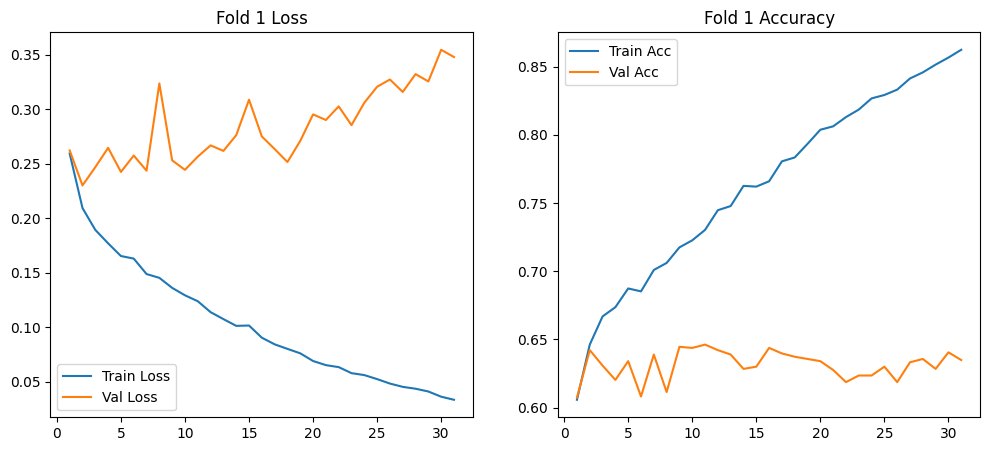

Fold 1 Final: Acc=0.635 Prec=0.630 Rec=0.635 F1=0.625


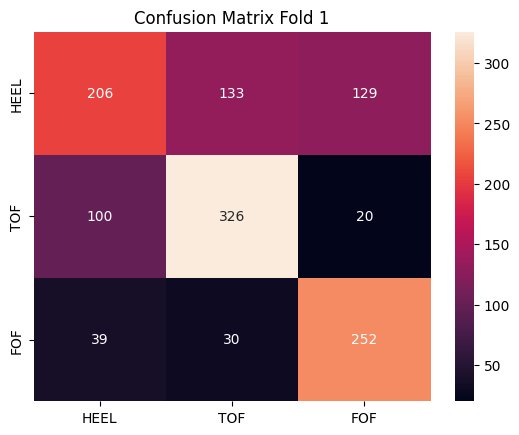


===== Fold 2/5 =====
After oversampling: Counter({np.int64(2): 1870, np.int64(1): 1870, np.int64(0): 1870})


/tmp/ipython-input-1384607563.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler=GradScaler()
/tmp/ipython-input-2847387484.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Acc=0.593 | Val Acc=0.645
Epoch 2: Train Acc=0.641 | Val Acc=0.665
Epoch 3: Train Acc=0.654 | Val Acc=0.621
Epoch 4: Train Acc=0.662 | Val Acc=0.653
Epoch 5: Train Acc=0.670 | Val Acc=0.647
Epoch 6: Train Acc=0.677 | Val Acc=0.666
Epoch 7: Train Acc=0.691 | Val Acc=0.625
Epoch 8: Train Acc=0.692 | Val Acc=0.661
Epoch 9: Train Acc=0.707 | Val Acc=0.642
Epoch 10: Train Acc=0.723 | Val Acc=0.654
Epoch 11: Train Acc=0.722 | Val Acc=0.652
Epoch 12: Train Acc=0.737 | Val Acc=0.647
Epoch 13: Train Acc=0.731 | Val Acc=0.660
Epoch 14: Train Acc=0.743 | Val Acc=0.662
Epoch 15: Train Acc=0.752 | Val Acc=0.643
Epoch 16: Train Acc=0.764 | Val Acc=0.663
Epoch 17: Train Acc=0.776 | Val Acc=0.653
Epoch 18: Train Acc=0.774 | Val Acc=0.646
Epoch 19: Train Acc=0.785 | Val Acc=0.653
Epoch 20: Train Acc=0.789 | Val Acc=0.668
Epoch 21: Train Acc=0.802 | Val Acc=0.649
Epoch 22: Train Acc=0.805 | Val Acc=0.644
Epoch 23: Train Acc=0.812 | Val Acc=0.652
Epoch 24: Train Acc=0.812 | Val Acc=0.659
E

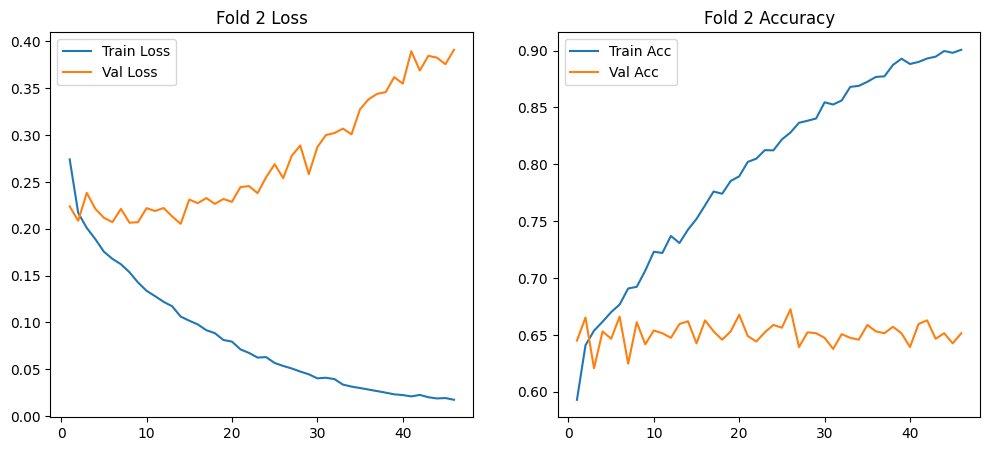

Fold 2 Final: Acc=0.652 Prec=0.648 Rec=0.652 F1=0.646


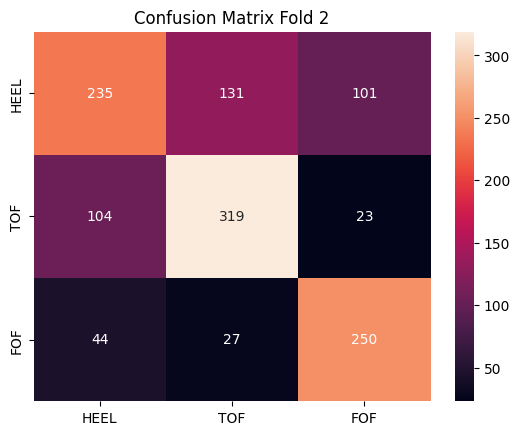


===== Fold 3/5 =====
After oversampling: Counter({np.int64(2): 1870, np.int64(1): 1870, np.int64(0): 1870})


/tmp/ipython-input-1384607563.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler=GradScaler()
/tmp/ipython-input-2847387484.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Acc=0.618 | Val Acc=0.578
Epoch 2: Train Acc=0.657 | Val Acc=0.583
Epoch 3: Train Acc=0.671 | Val Acc=0.587
Epoch 4: Train Acc=0.671 | Val Acc=0.600
Epoch 5: Train Acc=0.680 | Val Acc=0.593
Epoch 6: Train Acc=0.688 | Val Acc=0.612
Epoch 7: Train Acc=0.697 | Val Acc=0.600
Epoch 8: Train Acc=0.708 | Val Acc=0.634
Epoch 9: Train Acc=0.707 | Val Acc=0.624
Epoch 10: Train Acc=0.724 | Val Acc=0.618
Epoch 11: Train Acc=0.729 | Val Acc=0.632
Epoch 12: Train Acc=0.730 | Val Acc=0.630
Epoch 13: Train Acc=0.743 | Val Acc=0.612
Epoch 14: Train Acc=0.749 | Val Acc=0.638
Epoch 15: Train Acc=0.755 | Val Acc=0.627
Epoch 16: Train Acc=0.759 | Val Acc=0.622
Epoch 17: Train Acc=0.764 | Val Acc=0.600
Epoch 18: Train Acc=0.773 | Val Acc=0.647
Epoch 19: Train Acc=0.786 | Val Acc=0.626
Epoch 20: Train Acc=0.791 | Val Acc=0.621
Epoch 21: Train Acc=0.793 | Val Acc=0.628
Epoch 22: Train Acc=0.799 | Val Acc=0.630
Epoch 23: Train Acc=0.801 | Val Acc=0.620
Epoch 24: Train Acc=0.809 | Val Acc=0.627
E

KeyboardInterrupt: 

In [ ]:

cross_validate(frames,labels,'/content/drive/MyDrive/IMU/kFold_Results_ActivityRecog_new',k=5,epochs=200,batch_size=16,lr=5e-5)